# Introduction to ODSE datasets in Python

In this tutorial, you will learn how to access datasets produced whitin the scope [Open Data Science Europe (ODSE)](http://opendatascience.eu), a initiative co-financed by the European Union under the Grant Agreement Connecting Europe Facility (CEF) Telecom project [2018-EU-IA-0095](https://ec.europa.eu/inea/en/connecting-europe-facility/cef-telecom/2018-eu-ia-0095), which has the overall objective of producing and organizing various thematic geospatial data layers to support cross-border services over the entire continental Europe. The datasets produced/organized by ODSE are available through a [WebGIS viewer](http://maps.opendatascience.eu), a [metadata catalog](https://data.opendatascience.eu/geonetwork/) and [Cloud-Optimized GeoTIFF (COG) S3 service](https://opendatascience.eu/geo-harmonizer/geospatial-data-tutorial/).

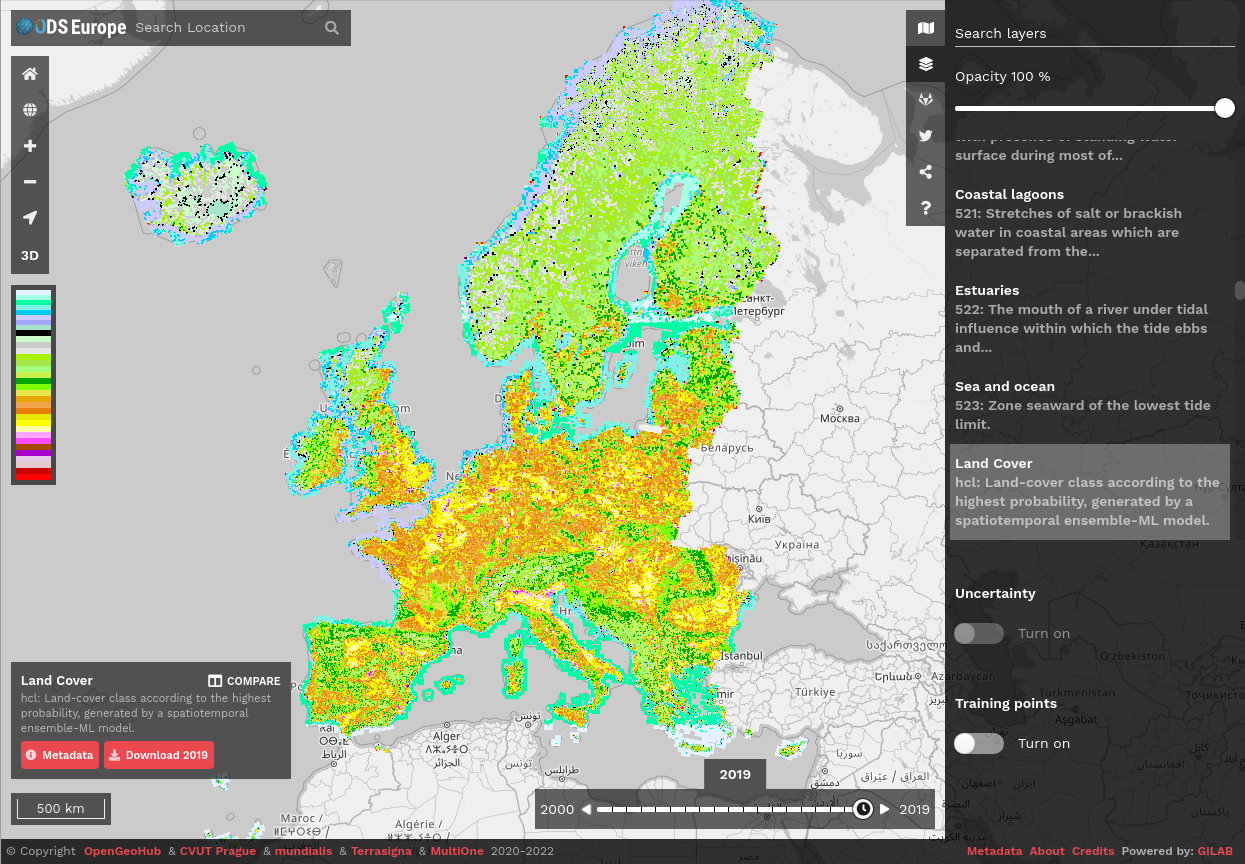

Seeking to optimize the preparation of the datasets, ODSE did use a specific [tiling system](https://gitlab.com/geoharmonizer_inea/spatial-layers#standard-tiling-system) with 7,042 regular cells (``30x30 km``) in the [ETRS89-extended / LAEA Europe](https://epsg.io/3035) projection system (``EPSG:3035``). To promote a better starting point, this tutorial is based in two pilot tiles extracted from the ODSE tiling system (``5606`` and ``14580``) and thousands of geospatial data layers (landsat spectral bands, dtm, land cover maps).

First, let's import some common python modules and libraries:

In [117]:
from pathlib import Path
import pandas as pd
import numpy as np
import geopandas as gpd

## Tiling System

The ODSE tiling system is available as [GeoPackage](https://www.geopackage.org/) through [S3 service](https://docs.aws.amazon.com/AmazonS3/latest/userguide/Welcome.html), a common [Cloud Object Storage](https://www.redhat.com/en/topics/data-storage/file-block-object-storage#:~:text=File%20storage%20organizes%20and%20represents,links%20it%20to%20associated%20metadata.) protocol. 

Let's use the [Geopandas](https://geopandas.org/about.html) to open it:

In [118]:
tiling_system_fn = 'http://s3.eu-central-1.wasabisys.com/eumap/tiling_system_30km.gpkg'
tiling_system = gpd.read_file(tiling_system_fn)
tiling_system

/opt/conda/lib/python3.8/site-packages/geopandas/geodataframe.py:577: RuntimeWarning: Sequential read of iterator was interrupted. Resetting iterator. This can negatively impact the performance.
  for feature in features_lst:


xl         yl         xu         yu   offst_y   offst_x  \
0     1770000.0   930010.0  1800000.0   960010.0  150000.0   29000.0   
1     1800000.0   930010.0  1830000.0   960010.0  150000.0   30000.0   
2     1890000.0   930010.0  1920000.0   960010.0  150000.0   33000.0   
3     1920000.0   930010.0  1950000.0   960010.0  150000.0   34000.0   
4     1950000.0   930010.0  1980000.0   960010.0  150000.0   35000.0   
...         ...        ...        ...        ...       ...       ...   
7037  5040000.0  5400010.0  5070000.0  5430010.0    1000.0  138000.0   
7038  5070000.0  5400010.0  5100000.0  5430010.0    1000.0  139000.0   
7039  4920000.0  5430010.0  4950000.0  5460010.0       0.0  134000.0   
7040  4950000.0  5430010.0  4980000.0  5460010.0       0.0  135000.0   
7041  4980000.0  5430010.0  5010000.0  5460010.0       0.0  136000.0   

      rgn_dm_y  rgn_dm_x  tile_id  \
0       1000.0    1000.0      217   
1       1000.0    1000.0      218   
2       1000.0    1000.0      221   
3       1000.0    1000.0      222   
4       1000.0    1000.0      223   
...        ...       ...      ...   
7037    1000.0    1000.0    28338   
7038    1000.0    1000.0    28339   
7039    1000.0    1000.0    28522   
7040    1000.0    1000.0    28523   
7041    1000.0    1000.0    28524   

                                               geometry  
0     POLYGON ((1770000.000 930010.000, 1770000.000 ...  
1     POLYGON ((1800000.000 930010.000, 1800000.000 ...  
2     POLYGON ((1890000.000 930010.000, 1890000.000 ...  
3     POLYGON ((1920000.000 930010.000, 1920000.000 ...  
4     POLYGON ((1950000.000 930010.000, 1950000.000 ...  
...                                                 ...  
7037  POLYGON ((5040000.000 5400010.000, 5040000.000...  
7038  POLYGON ((5070000.000 5400010.000, 5070000.000...  
7039  POLYGON ((4920000.000 5430010.000, 4920000.000...  
7040  POLYGON ((4950000.000 5430010.000, 4950000.000...  
7041  POLYGON ((4980000.000 5430010.000, 4980000.000...  

[7042 rows x 10 columns]

If this "boring" table has a geometry column, why not view this in a nicer way using [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/)?

In [119]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl

m = Map(center=(50,5), zoom = 3, basemap= basemaps.OpenStreetMap.Mapnik)

tiling_system_gd = GeoData(geo_dataframe = tiling_system.to_crs("EPSG:4326"),
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.6, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.2},
                   name = 'Tiling System')

m.add_layer(tiling_system_gd)
m.add_control(LayersControl())

m

Map(center=[50, 5], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_out_text…

This interactive map library has a lot of functions as supporting to multiple [basemaps](https://ipyleaflet.readthedocs.io/en/latest/api_reference/basemaps.html) and [searching over vector features](https://ipyleaflet.readthedocs.io/en/latest/api_reference/search_control.html).

## Raster Data

In the [VirtualBox machine](https://gitlab.com/geoharmonizer_inea/odse-workshop-2021/-/wikis/Training-session-preparation#virtualbox-machine), there are several raster layers clipped by the two pilot tiles (``5606`` and ``14580``):

To access these raster layers it's possible to use [GDAL python binding](https://gdal.org/api/python.html), [rasterio](https://rasterio.readthedocs.io/en/latest/quickstart.html) or [eumap](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.html#module-eumap.raster). Eumap is a python library developed by ODSE to enable easier access to the datasets prepared by the project as well the processing classes and functions used to produce them.

In [120]:
ODSE_DATA_DIR = Path.home().joinpath('ODSE_workdir').joinpath('data')
TILE_ID = 5606 # The other tile_id available is 14580

raster_dir = ODSE_DATA_DIR.joinpath(f'tile_{TILE_ID}')

print(f'ODSE data dir: {ODSE_DATA_DIR}')
print(f'Raster dir: {raster_dir}')

ODSE data dir: /home/opengeohub/ODSE_workdir/data
Raster dir: /home/opengeohub/ODSE_workdir/data/tile_14580


First, let's see how many files exists in the ``raster_dir``:

In [121]:
raster_files = list(raster_dir.glob('**/*.tif'))
print(f'Number of files: {len(raster_files)}')

Number of files: 3266


Here are the first 10 file paths

In [122]:
raster_files[0:10]

[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b3.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b5.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b6.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b7.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b4.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_b8.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_2018_14580_hcl.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv_land.cover_rf.prob_

... and file names

In [123]:
[ r.name for r in raster_files[0:10] ]

['lcv_land.cover_rf.prob_2018_14580_b2.tif',
 'lcv_land.cover_rf.prob_2018_14580_b3.tif',
 'lcv_land.cover_rf.prob_2018_14580_b5.tif',
 'lcv_land.cover_rf.prob_2018_14580_b6.tif',
 'lcv_land.cover_rf.prob_2018_14580_b7.tif',
 'lcv_land.cover_rf.prob_2018_14580_b4.tif',
 'lcv_land.cover_rf.prob_2018_14580_b1.tif',
 'lcv_land.cover_rf.prob_2018_14580_b8.tif',
 'lcv_land.cover_rf.prob_2018_14580_hcl.tif',
 'lcv_land.cover_rf.prob_2018_14580_hcl_prob.tif']

## Raster Summary

The best way to navigate over these thousands of files is understand the [ODSE file naming convention](https://gitlab.com/geoharmonizer_inea/spatial-layers#file-naming-convention)  and creating a raster summary. The layers are organized mainly in two categories: **timeless** (single year) and **temporal** (multi-year).

Let's use the ``eumap.misc.find_files``, which returns a sorted list with the found file paths.

The [DTM hillshade](https://zenodo.org/record/4724549#.YS9fA3UzYYs) is a **timeless** layer:

In [124]:
from eumap.misc import find_files
find_files(raster_dir, '*dtm_hillshade*.tif')

[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_hillshade.a315_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/dtm/dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif')]

The [Landsat red band (percentile 50)](https://opengeohub.medium.com/europe-from-above-space-time-machine-learning-reveals-our-changing-environment-1b05cb7be520) is a **temporal** layer:

In [125]:
temporal_files = find_files(raster_dir, '*red*landsat*p50*.tif')
print(f'Number of files: {len(temporal_files)}')
temporal_files[0:10]

Number of files: 84


[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2000.03.20_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2000.03.21..2000.06.24_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2000.06.25..2000.09.12_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2000.09.13..2000.12.01_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2000.12.02..2001.03.20_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p50_30m_0..0cm_2001.03.21..2001.06.24_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_red_landsat.glad.ard_p

Considering that, you can assume that the most part of the more the 3,000 raster layers available are **temporal**, and you can summarize them removing the date part from the filename. 

Here is the filename structure:

In [126]:
field_sep = '_'
field_names = [
    'Theme', 'Variable code', 'Variable estimation method', 'Variable estimation type', 
    'Spatial resolution', 'Vertical dimension', 'Reference period', 
    'Reference area', 'Coordinate system', 'Dataset version'
]

print('Filename fields:')
idx = 1
for i, value in zip(range(0,len(field_names)), temporal_files[idx].stem.split(field_sep)):
    print(f'{i} - {field_names[i]}: {value}')

Filename fields:
0 - Theme: lcv
1 - Variable code: red
2 - Variable estimation method: landsat.glad.ard
3 - Variable estimation type: p50
4 - Spatial resolution: 30m
5 - Vertical dimension: 0..0cm
6 - Reference period: 2000.03.21..2000.06.24
7 - Reference area: eumap
8 - Coordinate system: epsg3035
9 - Dataset version: v1.1


So to generate the raster summary it's necessary remove the field **6 - Reference period** and to a aggregation of all modified filenames, counting them and organizing as tabular result:

In [127]:
def summarize(raster_dir):

    raster_files = find_files(raster_dir, '*.tif')
    raster_summary = {}

    for f in raster_files:
        stem_arr = f.stem.split('_')
        stem_nodt = '_'.join(stem_arr[:6] + stem_arr[7:])

        if stem_nodt not in raster_summary:
            raster_summary[stem_nodt] = 0

        raster_summary[stem_nodt] += 1

    raster_summary = pd.DataFrame({'raster_names': raster_summary.keys(), 'n_files': raster_summary.values()})
    raster_summary = raster_summary.sort_values(by='n_files', ascending=False)
    
    return raster_summary

raster_summary = summarize(raster_dir)
raster_summary

raster_names  n_files
28   lcv_green_landsat.glad.ard_p25_30m_0..0cm_euma...       84
115  lcv_rgb_landsat.glad.ard_p50_30m_0..0cm_eumap_...       84
30   lcv_green_landsat.glad.ard_p75_30m_0..0cm_euma...       84
29   lcv_green_landsat.glad.ard_p50_30m_0..0cm_euma...       84
105  lcv_nir_landsat.glad.ard_p25_30m_0..0cm_eumap_...       84
..                                                 ...      ...
18   lcv_building.industrial_osm_p_30m_0..0cm_eumap...        1
17   lcv_building.commercial_osm_p_30m_0..0cm_eumap...        1
13   lcv_bare.earth_glad.umd_m_30m_0..0cm_eumap_eps...        1
114  lcv_reservoir_osm_p_30m_0..0cm_eumap_epsg3035_...        1
0    adm_county_nuts.osm_c_30m_0..0cm_eumap_epsg303...        1

[140 rows x 2 columns]

After remove the date part, there are 131 raster layers, which are organized in [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/user_guide/dsintro.html).

You can use this summary to search for layers of interest:

In [128]:
search = 'landcover'
raster_summary[raster_summary['raster_names'].str.contains(search)]

raster_names  n_files
73  lcv_landcover.323_lucas.corine.rf_p_30m_0..0cm...       20
59  lcv_landcover.222_lucas.corine.rf_p_30m_0..0cm...       20
72  lcv_landcover.323_lucas.corine.rf_md_30m_0..0c...       20
71  lcv_landcover.322_lucas.corine.rf_p_30m_0..0cm...       20
93  lcv_landcover.512_lucas.corine.rf_p_30m_0..0cm...       20
..                                                ...      ...
45  lcv_landcover.132_lucas.corine.rf_p_30m_0..0cm...       20
44  lcv_landcover.132_lucas.corine.rf_md_30m_0..0c...       20
43  lcv_landcover.131_lucas.corine.rf_p_30m_0..0cm...       20
91  lcv_landcover.511_lucas.corine.rf_p_30m_0..0cm...       20
41  lcv_landcover.12_pflugmacher2019_c_1m_s0..0m_e...        1

[69 rows x 2 columns]

## Timeless Data

Now with a clear view of what is available in the ``raster_dir``, and also a searchable summary, you can start reading the data using [eumap.raster module](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.html). This module has a few wrapper functions, build on top of [rasterio](https://rasterio.readthedocs.io/en/latest/quickstart.html), to read/save raster files in parallel, aggregating them into a single [Numpy array](https://numpy.org/doc/stable/user/absolute_beginners.html) structure, what will help you manage the temporal layers.

Let's start with the DTM hillshade layers, which are **timeless** layers:

In [129]:
from eumap.raster import read_rasters

raster_files = find_files(raster_dir, 'dtm_hillshade*.tif')
data, _ = read_rasters(raster_files=raster_files)
print(data.shape)

(1000, 1000, 2)


The first **two dimensions** are related with the space and the **last one** with the read layers:

In [130]:
print('Read layers:')
for i in range(0,data.shape[2]):
    print(f' - {raster_files[i].name}: {data[:,:,i].shape}')

Read layers:
 - dtm_hillshade.a315_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif: (1000, 1000)
 - dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif: (1000, 1000)


Let's use same basic Numpy functions to calculate the minimum, median and maximum pixel value, separately for each layer

In [131]:
print('Basic stats:')
def stats(raster_files, data):
    for i in range(0,data.shape[-1]):
        print(f' - {raster_files[i].name}: '
              + f' min={np.nanmin(data[:,:,i])}'
              + f' median={np.nanmedian(data[:,:,i])}'
              + f' max={np.nanmax(data[:,:,i])}'
        )

stats(raster_files, data)

Basic stats:
 - dtm_hillshade.a315_gedi.eml_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif:  min=204.0 median=253.0 max=255.0
 - dtm_hillshade.multid_gedi.gdal_m_30m_0..0cm_2000..2018_eumap_epsg3035_v0.2.tif:  min=107.0 median=181.0 max=215.0


...and a histogram plot to visualization the pixel distributions using [Matplotlib](https://matplotlib.org/):

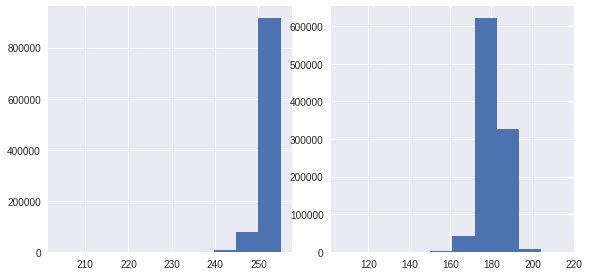

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
import math

def plot_hist(data, cols=4, figsize=(8,4), titles=[]):
    n_images = data.shape[2]
    rows = math.ceil(n_images / cols)
    
    fig, axs = plt.subplots(rows,cols, figsize=figsize)
    fig.tight_layout()
    
    for i in range(0,n_images):
        axs[i].hist(data[:,:,i].flatten())
        if len(titles) > i:
            axs[i].title.set_text(titles[i])

plot_hist(data, cols=2)

In the [eumap.plotter](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.plotter.html) you can find the wrapper function ``plot_rasters``, which enable a ready-to-go raster visualization. All [cmaps of maplotlib](https://matplotlib.org/stable/tutorials/colors/colormaps.html) are supported.

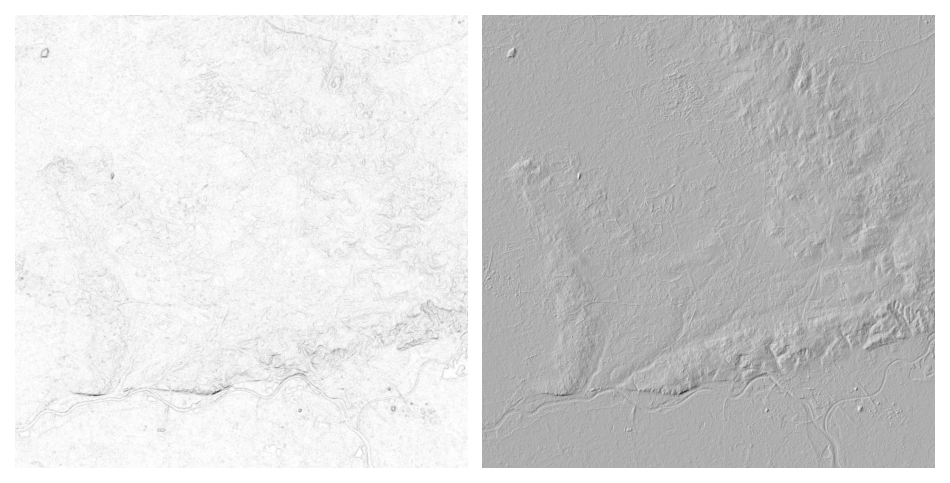

In [133]:
from eumap import plotter

plotter.plot_rasters(
    data[:,:,0].astype('uint8'), 
    data[:,:,1].astype('uint8'), 
    cmaps="gray",
    figsize=8
)

## Temporal Data

In the ODSE, the Landsat data was obtained from the [GLAD Landsat ARD](https://glad.geog.umd.edu/ard/glad-landsat-ard) ([Potapov et al., 2020](https://www.mdpi.com/2072-4292/12/3/426)). This product harmonized all Landsat sensors (TM, ETM+ and OLI) since 1997, using MODIS as reference, producing pixel values comparable across all Landsat satellites. The access to the data is free, although you need to request a username and password.

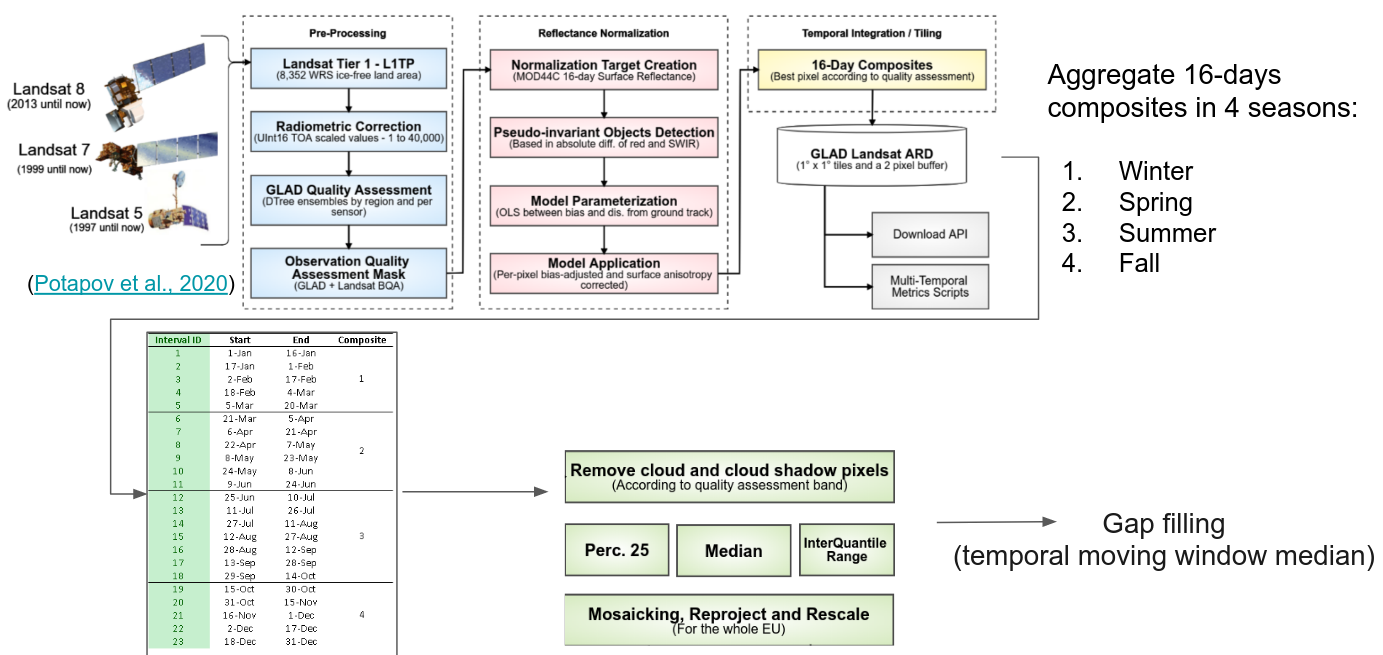

The GLAD ARD images were downloaded and organized in the temporal composites, considering the **four seasons** and **three percentiles** per season (25, 50 and 75), for **six spectral** (blue, green, red, NIR, SWIR1, SWIR2) and one **thermal band**, resulting at end in **88 Landsat composites per year**. The images for each season were selected using the same calendar dates for all period:
* Winter: December 2 of previous year until March 20 of current year
* Spring: March 21 until June 24 of current year
* Summer: June 25 until September 12 of current year
* Fall: September 13 until December 1 of current year

All composites had the clouds and cloud shadows removed ([eumap.gapfiller](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.datasets.eo.GLADLandsat.html#eumap.datasets.eo.GLADLandsat)) and were gapfilled ([eumap.gapfiller](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.gapfiller.TMWM.html#eumap.gapfiller.TMWM)) for the entire continental **Europe** and **21 years** (2000 - 2020). For each combination of band and percentile there are available a seamless and complete Landsat time series of size **84 (four seasons x twenty one years)**

In [134]:
raster_summary[raster_summary['raster_names'].str.contains('landsat')]

raster_names  n_files
28   lcv_green_landsat.glad.ard_p25_30m_0..0cm_euma...       84
115  lcv_rgb_landsat.glad.ard_p50_30m_0..0cm_eumap_...       84
30   lcv_green_landsat.glad.ard_p75_30m_0..0cm_euma...       84
29   lcv_green_landsat.glad.ard_p50_30m_0..0cm_euma...       84
105  lcv_nir_landsat.glad.ard_p25_30m_0..0cm_eumap_...       84
106  lcv_nir_landsat.glad.ard_p50_30m_0..0cm_eumap_...       84
111  lcv_red_landsat.glad.ard_p25_30m_0..0cm_eumap_...       84
112  lcv_red_landsat.glad.ard_p50_30m_0..0cm_eumap_...       84
16   lcv_blue_landsat.glad.ard_p75_30m_0..0cm_eumap...       84
15   lcv_blue_landsat.glad.ard_p50_30m_0..0cm_eumap...       84
14   lcv_blue_landsat.glad.ard_p25_30m_0..0cm_eumap...       84
113  lcv_red_landsat.glad.ard_p75_30m_0..0cm_eumap_...       84
107  lcv_nir_landsat.glad.ard_p75_30m_0..0cm_eumap_...       84
118  lcv_swir1_landsat.glad.ard_p25_30m_0..0cm_euma...       84
123  lcv_swir2_landsat.glad.ard_p75_30m_0..0cm_euma...       84
119  lcv_swir1_landsat.glad.ard_p50_30m_0..0cm_euma...       84
124  lcv_thermal_landsat.glad.ard_p25_30m_0..0cm_eu...       84
125  lcv_thermal_landsat.glad.ard_p50_30m_0..0cm_eu...       84
122  lcv_swir2_landsat.glad.ard_p50_30m_0..0cm_euma...       84
121  lcv_swir2_landsat.glad.ard_p25_30m_0..0cm_euma...       84
120  lcv_swir1_landsat.glad.ard_p75_30m_0..0cm_euma...       84
126  lcv_thermal_landsat.glad.ard_p75_30m_0..0cm_eu...       84

First, let's retrieve the three available percentile for summer/2018 (``2018.06.25..2018.09.12``)

In [135]:
raster_files = find_files(raster_dir, 'lcv_nir_landsat.glad.ard_*2018.06.25..2018.09.12*.tif')
raster_files

[PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_nir_landsat.glad.ard_p25_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_nir_landsat.glad.ard_p50_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif'),
 PosixPath('/home/opengeohub/ODSE_workdir/data/tile_14580/lcv/lcv_nir_landsat.glad.ard_p75_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif')]

... and load them as Numpy array:

In [136]:
data, _ = read_rasters(raster_files=raster_files)
print(data.shape)

(1000, 1000, 3)


Let's check the minimum, median and maximum

In [137]:
stats(raster_files, data)

 - lcv_nir_landsat.glad.ard_p25_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif:  min=1.0 median=60.0 max=195.0
 - lcv_nir_landsat.glad.ard_p50_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif:  min=1.0 median=62.0 max=195.0
 - lcv_nir_landsat.glad.ard_p75_30m_0..0cm_2018.06.25..2018.09.12_eumap_epsg3035_v1.1.tif:  min=1.0 median=65.0 max=195.0


...and the histogram:

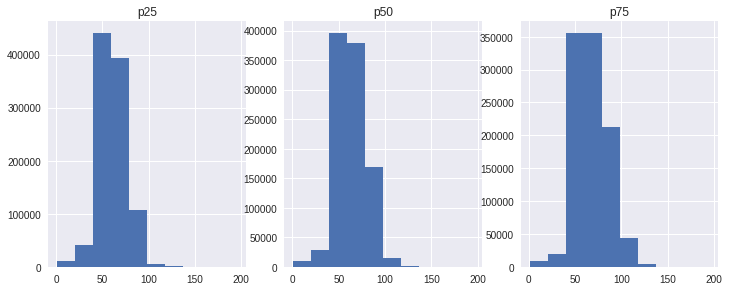

In [138]:
titles = [ raster_files[i].stem.split('_')[3] for i in range(0, 3)]
plot_hist(data, cols=3, figsize=(10,4), titles=titles)

Using a simple visualization of the layers it's not possible see much difference:

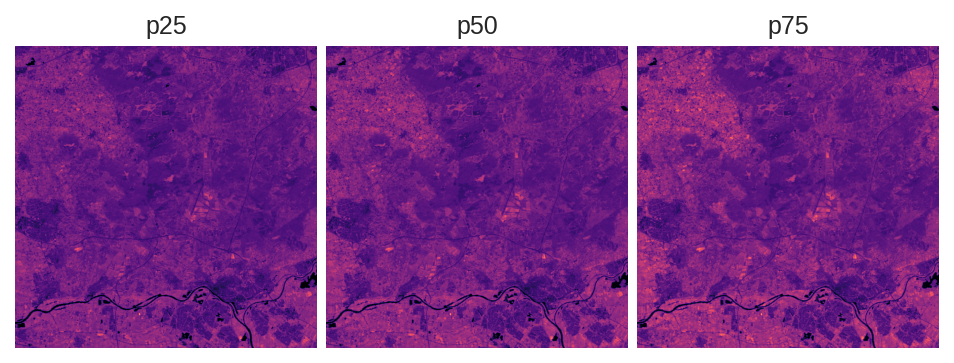

In [139]:
data_arr = [ data[:,:,i].astype('uint8') for i in range(0, 3)]
title_arr = [ raster_files[i].stem.split('_')[3] for i in range(0, 3)]

plotter.plot_rasters(*data_arr, cmaps="magma", figsize=8, titles=title_arr)

Now, let's retrieve the complete time series for the NIR band and percentile 50.  

In [140]:
raster_files = find_files(raster_dir, 'lcv_nir_landsat.glad.ard_p50*.tif')
data, _ = read_rasters(raster_files=raster_files)
data.shape

(1000, 1000, 84)

How the time series looks like?

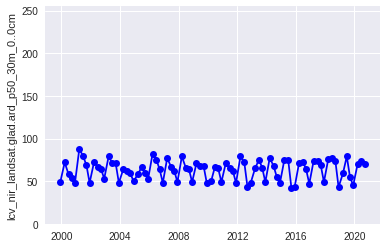

In [141]:
import matplotlib

def plot_ts(raster_files, values, axis_title=None):
    dates = [ raster_files[i].stem.split('_')[6].split('..')[0].replace('.','-') for i in range(0, len(raster_files))]
    dates = matplotlib.dates.date2num(dates)

    if axis_title is None:
        axis_title = '_'.join(raster_files[0].name.split('_')[0:6])

    fig, ax = plt.subplots()

    plt.style.use('seaborn')
    ax.plot_date(dates, values, 'bo-')
    plt.ylim(0,255)
    ax.set_ylabel(axis_title)
    plt.show()

i, j = 700,710 
plot_ts(raster_files, data[i,j,:])

You can also visualize the **four seasons** at once and compare different years: 

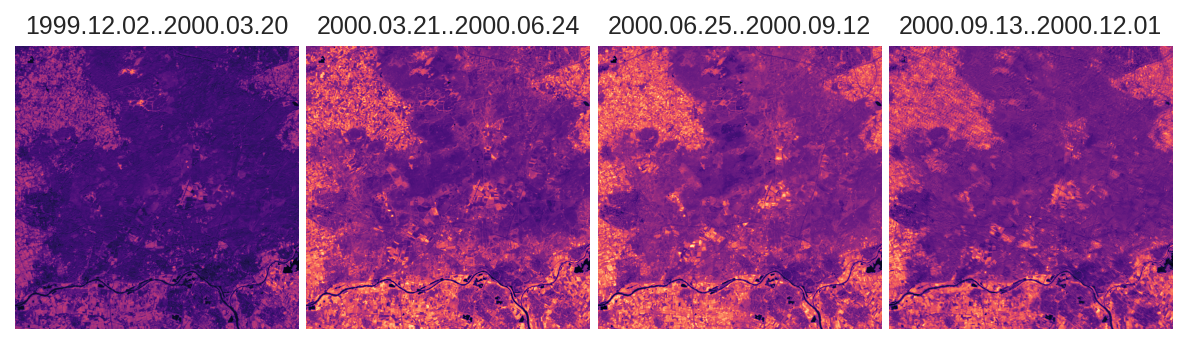

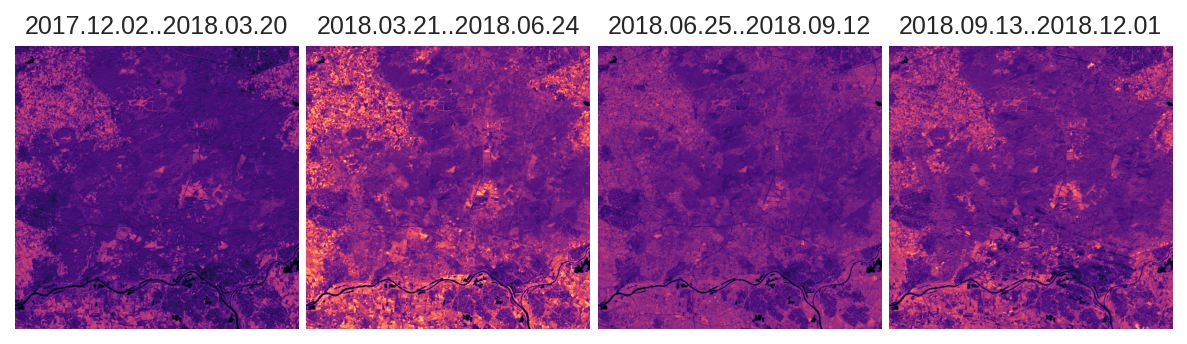

In [142]:
def plot_landsat(data, raster_files, year, dt_position = 6):
    data_arr, title_arr = [], []
    
    for i in range(0, len(raster_files)):
        raster_dt = raster_files[i].stem.split('_')[dt_position]
        raster_year = raster_dt.split('..')[1].split('.')[0]
        
        if raster_year == str(year):
            data_arr.append(data[:,:,i].astype('uint8'))
            title_arr.append(raster_dt)
    
    plotter.plot_rasters(*data_arr, cmaps="magma", figsize=10, titles=title_arr)
    
plot_landsat(data, raster_files, '2000')
plot_landsat(data, raster_files, '2018')

With the temporal data organized in a Numpy array you can perform multiple operations reducing the data dimensions. 

To demonstrate it let's calculate a median time series and a median image for the current tile:

In [143]:
mendian_ts = np.nanmedian(data, axis=(0,1))
mendian_img = np.nanmedian(data, axis=2)

print(f'median_ts: {mendian_ts.shape}')
print(f'mendian_img: {mendian_img.shape}')

median_ts: (84,)
mendian_img: (1000, 1000)


You can visualize them using the same approach:

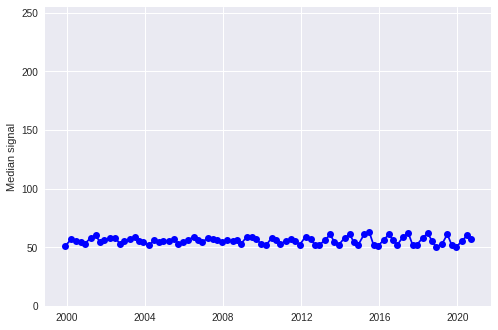

In [144]:
plot_ts(raster_files, mendian_ts, axis_title='Median signal')

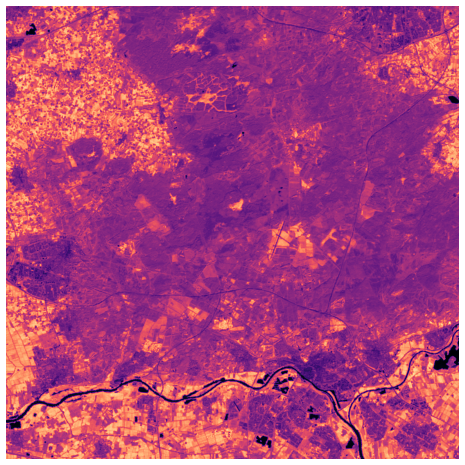

In [145]:
plotter.plot_rasters(mendian_img.astype('uint8'), cmaps="magma", dpi=60)

As last step, you can save the median image as GeoTIFF using [eumap.raster module](https://eumap.readthedocs.io/en/latest/_autosummary/eumap.raster.save_rasters.html#eumap.raster.save_rasters), keeping the filename standard and later visualize it in [QGIS](https://www.qgis.org/en/site/):

In [146]:
from eumap.raster import save_rasters

prefix = '_'.join(raster_files[0].name.split('_')[0:6])
suffx = '_'.join(raster_files[0].name.split('_')[8:])
dt1 = raster_files[0].name.split('_')[6].split('..')[0]
dt2 = raster_files[len(raster_files)-1].name.split('_')[6].split('..')[1]
median_fn =  ODSE_DATA_DIR.joinpath(f'{prefix}_{dt1}..{dt2}_{suffx}')

save_rasters(raster_files[0], [median_fn], mendian_img)

[PosixPath('/home/opengeohub/ODSE_workdir/data/lcv_nir_landsat.glad.ard_p50_30m_0..0cm_1999.12.02..2020.12.01_epsg3035_v1.1.tif')]